<a href="https://colab.research.google.com/github/Hikanyona/Mytest/blob/master/Atna_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connect to google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 8)


In [85]:
datar = pd.read_csv("/content/drive/My Drive/NVE/atna.csv", sep=';', header='infer',
                   dayfirst=True,
                   index_col=0, # you can use the date as the index for pandas
                   parse_dates=[0]) # where is the time stamp?)
datar.head()

,P,T,Q
Date,,,
1981-01-01,0.43,-7.91,4.136
1981-01-02,0.33,-8.25,3.955
1981-01-03,0.00,-13.08,3.955
1981-01-04,0.03,-18.60,3.778
1981-01-05,0.00,-22.87,3.778


In [0]:
cols_plot = [ 'P', 'T', 'Q']

axes =data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Precip', 'Temp','Riverflow')

Add columns of days and month as part of the dataset


In [0]:
#data['jday'] = data.index.dayofyear
#data['ymon'] = data.index.month
#datar = data[['jday','ymon','P','T','Q']]
#datar.head()
#test_X.shape[0]

Testing more ....Check here please 

In [101]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


n_features = X.shape[2]


# frame as supervised learning
reframed = series_to_supervised(datar, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_days = 7300 
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# design network
#model = Sequential()
#model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=100,  validation_data=(test_X, test_y))
history = model.fit(train_X, train_y, epochs=200, verbose=0)
model.summary()
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

            var1(t)  var2(t)  var3(t)
Date                                 
1981-01-02     0.33    -8.25    3.955
1981-01-03     0.00   -13.08    3.955
1981-01-04     0.03   -18.60    3.778
1981-01-05     0.00   -22.87    3.778
1981-01-06     0.00   -22.38    3.605
(7300, 1, 2) (7300,) (4021, 1, 2) (4021,)


ValueError: ignored

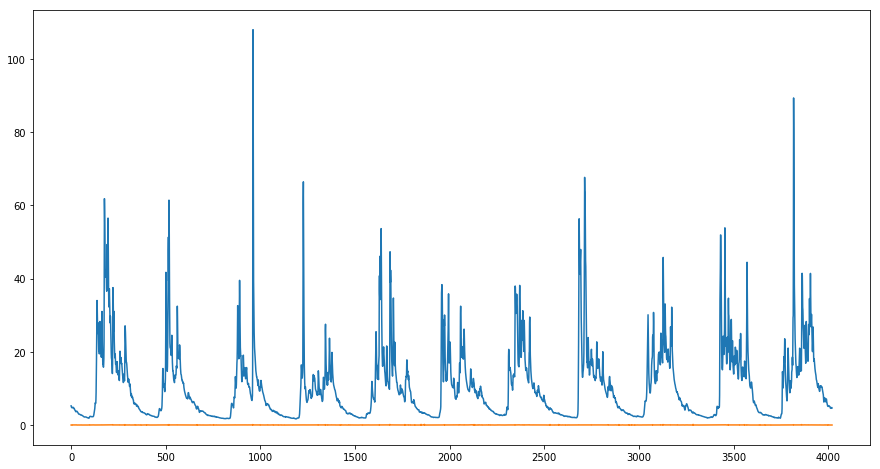

In [97]:
plt.plot(inv_y)
plt.plot(inv_yhat)

Convert to  numpy data type

In [18]:
datan = data.to_numpy()
datan


array([[  0.43 ,  -7.91 ,   4.136],
       [  0.33 ,  -8.25 ,   3.955],
       [  0.   , -13.08 ,   3.955],
       ...,
       [  4.29 ,  -5.69 ,   4.773],
       [  0.05 ,  -7.52 ,   4.772],
       [  0.92 , -12.27 ,   4.646]])

Define a function to split sequences 

In [0]:
# split a multivariate sequence into samples
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [49]:
n_steps_in = 3
n_steps_out = 2

# convert into input/output
X, y = split_sequences(datan, n_steps_in,n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(11319, 3, 2) (11319, 2)
[[  0.43  -7.91]
 [  0.33  -8.25]
 [  0.   -13.08]] [3.955 3.778]
[[  0.33  -8.25]
 [  0.   -13.08]
 [  0.03 -18.6 ]] [3.778 3.778]
[[  0.   -13.08]
 [  0.03 -18.6 ]
 [  0.   -22.87]] [3.778 3.605]
[[  0.03 -18.6 ]
 [  0.   -22.87]
 [  0.   -22.38]] [3.605 3.605]
[[  0.   -22.87]
 [  0.   -22.38]
 [  1.48 -18.4 ]] [3.605 3.605]
[[  0.   -22.38]
 [  1.48 -18.4 ]
 [  7.79 -14.09]] [3.605 3.436]
[[  1.48 -18.4 ]
 [  7.79 -14.09]
 [  0.43  -5.86]] [3.436 3.436]
[[  7.79 -14.09]
 [  0.43  -5.86]
 [  6.18  -5.69]] [3.436 3.436]
[[ 0.43 -5.86]
 [ 6.18 -5.69]
 [ 0.04 -7.48]] [3.436 3.436]
[[ 6.18 -5.69]
 [ 0.04 -7.48]
 [ 3.89 -5.47]] [3.436 3.436]
[[ 0.04 -7.48]
 [ 3.89 -5.47]
 [ 0.   -8.03]] [3.436 3.436]
[[  3.89  -5.47]
 [  0.    -8.03]
 [  1.09 -10.94]] [3.436 3.436]
[[  0.    -8.03]
 [  1.09 -10.94]
 [  3.85 -12.68]] [3.436 3.436]
[[  1.09 -10.94]
 [  3.85 -12.68]
 [  6.36  -9.84]] [3.436 3.436]
[[  3.85 -12.68]
 [  6.36  -9.84]
 [  5.68  -9.73]] [3.436 3.272]
[[ 

In [46]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
1.14.0



Ready to fit an LSTM model on data

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Input

ENCODER_SIZE = 128
DECODER_SIZE = 128

ENCODING_DIM = 256

model = Sequential()

# ENCODER

model.add(Input(shape=(n_steps_in, n_features), name='Input'))


# model.add(LSTM(units=ENCODER_SIZE, activation='relu', name="encode1r", return_sequences=True))
model.add(LSTM(units=ENCODER_SIZE, activation='relu', name="encoder2"))


# LATENT SPACE

model.add(Dense(units=ENCODING_DIM, activation='relu', name="latent_space1"))
model.add(Dense(units=ENCODING_DIM, activation='relu', name="latent_space2"))

# DECODER

model.add(RepeatVector(n_steps_out))

# return_sequences=True tells it to keep all temporal outputs, not only the final one (we need all of them for our predicted sequence)
model.add(LSTM(units=DECODER_SIZE, activation='relu', return_sequences=True, name="decoder"))

model.add(Dense(units=1))
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='mse')
# model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder2 (LSTM)              (None, 128)               66560     
_________________________________________________________________
latent_space1 (Dense)        (None, 256)               33024     
_________________________________________________________________
latent_space2 (Dense)        (None, 256)               65792     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 256)            0         
_________________________________________________________________
decoder (LSTM)               (None, 2, 128)            197120    
_________________________________________________________________
dense_1 (Dense)              (None, 2, 1)              129       
Total params: 362,625
Trainable params: 362,625
Non-trainable params: 0
________________________________________________

In [0]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
model.summary()

In [57]:
X.shape[2]

2